In [1]:
from jupyterquiz import display_quiz
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt

# Holonomic Quantum Computing

## Why?

- Rely on stable topological features to produce unitary operators
- The hope is that (in practice) the topological features provide more error tolerance
- Loops in the control manifold can induce a unitary operator that depends on the _area_ of the loop

## Review of geometric phase via Adiabatic Evolution

Consider

$$
H = \vec{n}(t) \cdot \vec{\sigma} = \begin{pmatrix} \cos \theta & e^{-i\phi} \sin \theta \\ e^{i\phi}\sin\theta & -\cos\theta \end{pmatrix} \Rightarrow H(\theta, \phi)
$$

Let the system start in the eigenstate:

$$
|\psi_1(t)\rangle = \cos(\theta/2) |0\rangle + e^{i\phi} \sin(\theta/2) |1\rangle
$$

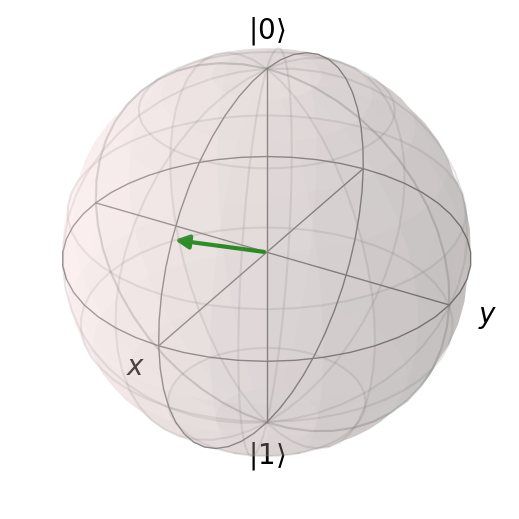

In [2]:
theta_0 = np.pi / 3 # we will keep theta constant
phi_0 = 0 # we will rotate phi

psi_0 = np.cos(theta_0/2) * qp.basis(2,0) + np.exp(1j * phi_0) * np.sin(theta_0/2) * qp.basis(2,1)

b = qp.Bloch()
b.add_states(psi_0)
b.show()

In [3]:
phi_f = 2*np.pi

tau = 2**10 * np.pi

def angle(t):
    return (1 - (t/tau))* phi_0 + (t/tau) * phi_f

H = [
    [qp.sigmax(), (lambda t, args: np.sin(theta_0) * np.cos(-angle(t)))],
    [qp.sigmay(), (lambda t, args: np.sin(theta_0) * np.sin(-angle(t)))],
    [qp.sigmaz(), (lambda t, args: np.cos(theta_0))]
]

t_range = np.linspace(0, tau, 100)

result = qp.mesolve(H, psi_0, t_range)

Our Hamiltonian is cyclic! $H(\pi/3, 0) = H(\pi/3, 2\pi)$. Let us plot the $B$ field along with initial state.

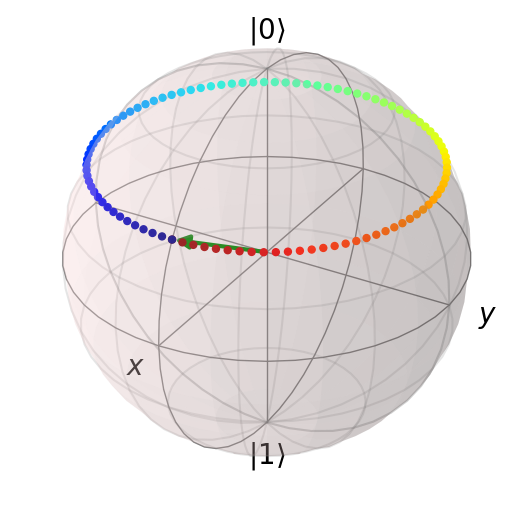

In [4]:
# plot the control

from matplotlib import cm, colors

nrm = colors.Normalize()
colors = cm.jet(nrm(t_range))

b.point_color = colors

b.add_points([np.sin(theta_0) * np.cos(-angle(t_range)), np.sin(theta_0) * np.sin(-angle(t_range)), [np.cos(theta_0) for _ in t_range]], 'm')

b.show()

Let us plot the final state

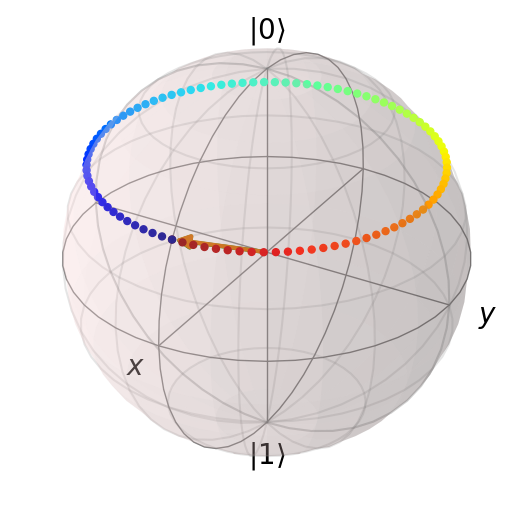

In [5]:
b.add_states(result.states[-1])
b.show()

In [6]:
overlap = result.states[-1].overlap(psi_0)
print(f'State similarity: {np.abs(overlap)**2}')

State similarity: 0.9999992855589531


In [7]:
gamma = np.pi * (np.cos(theta_0) - 1)
expected = np.exp(1j * gamma)
print(f'Calculated {overlap}\nExpected {expected}')

Calculated (-0.0004978402668791111-0.9999995188568952j)
Expected (5.053215498074303e-16-1j)


## The Math

The eigenstate equation:

$$
 H(t)|\psi_n(t)\rangle = E_n(t) |\psi_n(t)\rangle
$$

A general state can be written in terms of eignestates:

$$
|\phi(t)\rangle = \sum_n c_n(t) e^{i \theta_n(t)} |\psi_n(t)\rangle
$$

where

$$
\theta_n(t) = - \int_0^t E_n(t^\prime) dt^\prime
$$

and is known as the _dynamical phase_.

By plugging the general state into the Schrondinger equation, we arrive at:

$$
\sum_n e^{i\theta_n(t)} \left [ \dot c_n(t) |\psi_n(t)\rangle + c_n(t) \frac{d}{dt} |\psi_n(t)\rangle \right] = 0
$$

Assuming there is no degeneracy, one particular amplitude in the eigenbasis gives

$$
\dot c_m(t) = -c_m(t) \langle \psi_m(t)| \left [ \frac{d}{dt} |\psi_m(t)\rangle \right] - \sum_n c_n(t) e^{i(\theta_n - \theta_m)} \frac{\langle \psi_m| H |\psi_n \rangle}{E_n - E_m}
$$

If the Hamiltonian evolves slowly in time compared to the difference between energy level, then the second term goes away, which results in

$$
    c_n(t) = e^{i \gamma(t)} c_n(0)
$$

where

$$
    \gamma_n(t) = i \int_0^t \langle \psi_n(t^\prime)| \left [ \frac{d}{dt} | \psi_n(t^\prime) \rangle \right] dt^\prime
$$

This phase is known as _Berry's Phase_.

Suppose the Hamiltonian's time dependence can be described by a vector of parameters $\mathbf{R}(t)$. Then the integrand from Berry's phase can be written as:

$$
 i \langle \psi_n(\mathbf{R})| \left [ \frac{d}{dt} | \psi_n(\mathbf{R}) \rangle \right] = i \langle \psi_n(\mathbf{R})|\nabla_\mathbf{R} |\psi_n(\mathbf{R})\rangle \cdot \frac{d\mathbf{R}}{dt} = \mathbf{A}_n(\mathbf{R}) \cdot \frac{d\mathbf{R}}{dt}
$$

So the integral can then be evaluated along a curve in parameter space

$$
\gamma_n(T) = i \int_0^T \mathbf{A_n}(\mathbf{R}) \cdot \frac{d\mathbf{R}}{dt} dt = \int_C \mathbf{A}_n(\mathbf{R}) \cdot d\mathbf{R}
$$

If the time evolution is cyclic, with period T such that $\mathbf{R}(0)= \mathbf{R}(T)$, then by Stokes' theorem:

$$
\gamma_n(T) = \oint_C \mathbf{A}_n(\mathbf{R}) \cdot d\mathbf{R} = \int [\nabla_\mathbf{R} \times \mathbf{A}_n(\mathbf{R})] \cdot d\mathbf{a}
$$
where $d\mathbf{a}$ is a vector of measures for each parameter.

# Review of non-Abelian Generalization of Geometric Phase (holonomy)

- Holonomy refers to the set of closed curves starting and ending at some point, they form a _group_
- The geometric phase is a _abelian representation_ of an holonomy group -- any loop is associated with a geometric phase factor and they commute: $e^{i\gamma_1} e^{i\gamma_2} = e^{i\gamma_2}e^{i\gamma_1}$
- So a _non-abelian_ generalization can be represented by matrices
- Can be shown by inspecting a degenerate subspace subject to an adiabatic evolution

## The Math (2)

Previously, we made the assumption that there was no degeneracy. However, suppose our initial state belongs to a degenerate subspace. Then following the same treatment, the system will stay within the subspace. The time evolution of the coefficient will now include an additional sum:

$$
    \dot c_m(t) = -\sum_n c_n(t) \langle \psi_m(t) | \left [\frac{d}{dt} |\psi_n(t) \rangle \right ] = i M_{mn}(t) c_n(t)
$$

The solution is now a matrix exponential

$$
c_m(t) = T \exp\left \{ i \int_0^t dt M_{mn}(t) \right \} c_n(0)
$$

where $T$ is the time-ordering operator. 

In the case we have vectors, then we define

$$
\mathbf{A}_{mn}(\mathbf{R}) = \langle \psi_m(\mathbf{R}) | \nabla_{\mathbf{R}} | \psi_n(\mathbf{R}) \rangle
$$

A unitary is then implemented in the subspace

$$
U(T) = P \exp \left \{ i \int_C \mathbf{A}_{mn}(\mathbf{R}) \cdot d\mathbf{R} \right\}
$$

# Review of nonadiabatic Holonomic Quantum Computation


- Assume an $N$-dimensional quantum system subject to a Hamiltonian $H(t)$
- Assume there is an $L$-dimensional subspace, $S(t) = span\{|\phi_k\rangle\}_{k=1}^L$ where $|\phi_k(t)\rangle$ are orthonormal vectors and satisfy the divine equation: $i \frac{d}{dt}|\phi_k(t)\rangle = H(t)\phi_k(t)\rangle$
- There is a unitary operator $U(\tau)$, $|\phi_k(\tau)\rangle = U(\tau)|\phi_k(0)\rangle$, if $|\phi_k(t)\rangle$ satisfy:
    1. $$\sum_{k=1}^L |\phi_k(\tau)\rangle\langle \phi_k(\tau)| = \sum_{k=1}^{L} |\phi_k(0)\rangle\langle \phi_k(0)|$$
    2. $$\langle \phi_k(t)| H(t) |\phi_l(t)\rangle = 0, \quad k,l = 1,...,L$$


## Nonadiabatic Holonomic Qubit Gate (via 3 levels)

Suppose the Hamiltonian (in the interaction picture) is:

$$
H(t) = \frac{\Omega(t)}{2} (a|e\rangle \langle 0| + b |e\rangle \langle 1| + h.c.)
= \frac{\Omega(t)}{2}\begin{pmatrix} 0 & a & 0 \\ a^* & 0 & b \\ 0 & b^* & 0 \end{pmatrix}
$$

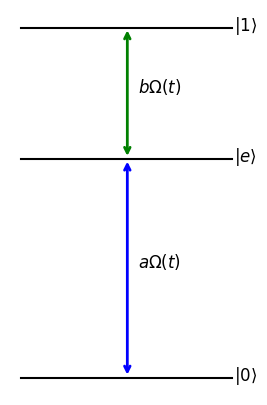

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 5))
ax = fig.subplots()
line = np.arange(0,1,0.01)
ax.plot(line, 0 * line, c='black')
ax.plot(line, 1 + 0* line, c='black')
ax.plot(line, 1.6 + 0* line, c='black')

ax.annotate("",
            xy=(0.5, 0), xycoords='data',
            xytext=(0.5, 1), textcoords='data',
            horizontalalignment="center",
            arrowprops=dict(arrowstyle="<->",
                            color='blue',
                            lw=2),
            )
ax.annotate("",
            xy=(0.5, 1), xycoords='data',
            xytext=(0.5, 1.6), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            color='green',
                            lw=2),
            )
ax.text(0.55, 0.5, r"$a\Omega(t)$", fontsize='large')
ax.text(0.55, 1.3, r"$b\Omega(t)$", fontsize='large')

ax.text(1.0, -0.015, r"$|0\rangle$", fontsize='large')
ax.text(1.0, 1 - 0.015, r"$|e\rangle$", fontsize='large')
ax.text(1.0, 1.6 - 0.015, r"$|1\rangle$", fontsize='large')

ax.axis('off')
plt.show()

$|0\rangle$ and $|1\rangle$ evolve to states:

$$
|\psi_0(t)\rangle = T \exp \left[ \int_0^t H(t^\prime) dt^\prime \right] |0\rangle
$$

and

$$
|\psi_1(t)\rangle = T \exp \left[ \int_0^t H(t^\prime) dt^\prime \right] |1\rangle
$$

By keeping the ratio between $a/b$ constant, the evolution satisfies

$$
\langle \psi_i(t)| H(t) | \psi_j(t) \rangle = 0
$$

If the pulse length $\tau$ is such that $\int_0^\tau \Omega(t) dt = 2\pi$ then the operator acting on $span[|0\rangle, |1\rangle]$ is:

$$
U(C) = \begin{pmatrix} \cos \theta & e^{i\phi}\sin\theta \\ e^{-i\phi}\sin\theta & -\cos\theta \end{pmatrix}
$$

where $e^{i\phi}\tan\theta/2 = a/b$

Integral: 6.2831853071795845


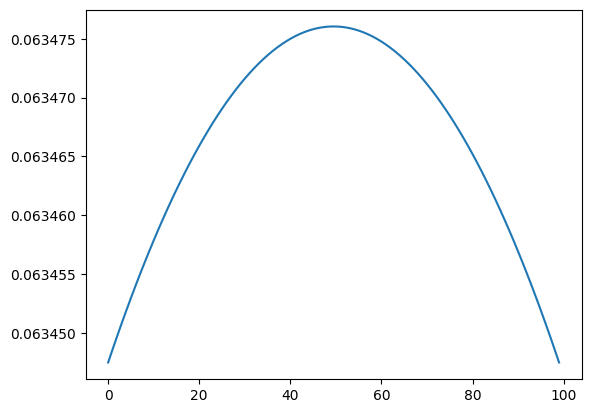

In [9]:
def U_C(theta, phi=0):
    return np.array([[np.cos(theta), np.exp(1j * phi) * np.sin(theta)],
                     [np.exp(-1j * phi) * np.sin(theta), -np.cos(theta)]])

def get_a_b(theta, phi=0, a=1):
    left = np.exp(1j * phi) * np.tan(theta/2)
    b = a / left
    norm = np.sqrt(np.abs(a)**2 + np.abs(b)**2)
    return (a/norm, b/norm)

res = 100

t = np.linspace(-3, +3, res)
sigma = 0.01
ip = np.exp((-.5* sigma**2) * t ** 2)
gaussian_pulse = 2*np.pi / np.trapz(ip)  * ip

print(f"Integral: {np.trapz(gaussian_pulse)}")
plt.plot(gaussian_pulse)
plt.show()

In [10]:
theta = np.pi / 4
phi = np.pi

print(f"Expected Unitary:\n{U_C(theta)}")

Expected Unitary:
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


In [11]:
ket_0 = np.array([[1],[0],[0]])
ket_e = np.array([[0],[1],[0]])
ket_1 = np.array([[0],[0],[1]])

a, b = get_a_b(theta, phi)

H = a * ket_e @ ket_0.conj().T + b * ket_e @ ket_1.conj().T
H = H + H.conj().T

In [12]:
t_range = np.linspace(0, res, res)

H_qobj = [0.5 * qp.Qobj(H), gaussian_pulse]

result = qp.mesolve(H_qobj, qp.Qobj(ket_0), t_range)

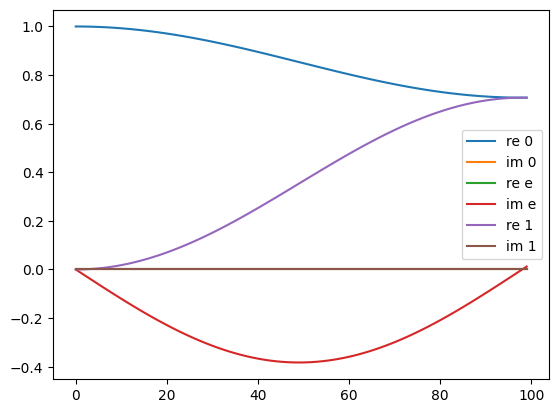

In [13]:
plt.plot([r.full()[0][0].real for r in result.states], label='re 0')
plt.plot([r.full()[0][0].imag for r in result.states], label='im 0')

plt.plot([r.full()[1][0].real for r in result.states], label='re e')
plt.plot([r.full()[1][0].imag for r in result.states], label='im e')

plt.plot([r.full()[2][0].real for r in result.states], label='re 1')
plt.plot([r.full()[2][0].imag for r in result.states], label='im 1')
plt.legend()
plt.show()

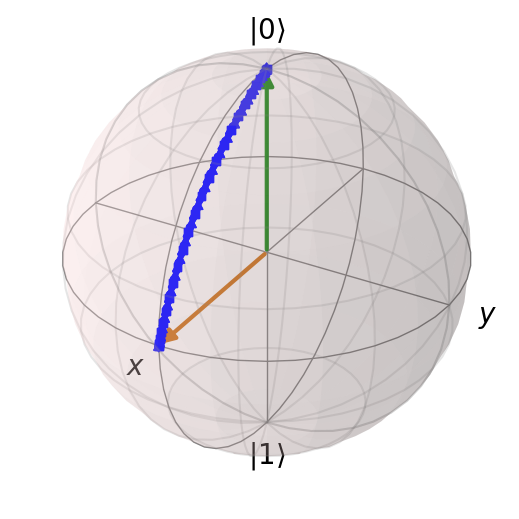

In [14]:
qubit_states = [r.eliminate_states([1]) for r in result.states]
bh = qp.Bloch()
bh.point_color = ['b']
bh.add_states(qubit_states, 'point')
bh.add_states([qubit_states[0], qubit_states[-1]])
bh.show()